# ``Taming Performance Variability''

### <font color='red'> Notebook for the high-level analysis of normality (or lack of it) in the collected data.</font>

In [32]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks

#import matplotlib
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

warnings.filterwarnings(action='once')

# With plot_show_and_save() defined below, there is no need for this configuration
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/raw-data/"
# Save all dataframes and plots into this directory 
dest_dir = "output/paper/"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

# db -- dictinary with keys - table names, values - dataframes with table data
db = {}

for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed throughout the notebook
verbose = True
if verbose:
    print "Keys: ", db.keys()
    for k, df in db.iteritems():
        #print "Sample from %s:" % k 
        #print df.head(3), "\n\n" 
        print "Columns in %s:" % k, df.columns.tolist(), "\n"

####  Define default graphics parameters ###

####  Include common helper functions
sys.path.append("bench-lib/")
from common import *

Keys:  ['disk_info', 'iperf3_info', 'iperf3_results', 'ping_results', 'env_info', 'membench_info', 'disk_results', 'fio_info', 'stream_info', 'network_info', 'mem_results', 'ping_info']
Columns in disk_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'disk_name', 'disk_model', 'disk_serial', 'disk_size', 'npartitions', 'disk_type'] 

Columns in iperf3_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'version', 'local_ip', 'local_port', 'remote_ip', 'remote_port', 'remote_nodeid', 'protocol', 'num_streams', 'buffer_size', 'omitted_intervals', 'duration', 'time_units'] 

Columns in iperf3_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'reverse', 'retransmits', 'local_cpu_util', 'remote_cpu_util', 'median', 'max', 'min', 'mean', 'stdev', 'sum_sent', 'sum_received', 'units'] 

Columns in ping_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'runtime', 'packets_sent', 'packets_received', 'packet_loss', 'max', 'min', 'mean', 'stdev', 'ipg', 'ewma', 'units'] 

Colu

In [33]:
# Print high-level info 

print "The earliest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].min())
print "The latest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].max())

print "The earliest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].min())
print "The latest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].max())

print "Total number of samples: ", len(db['disk_results'])

db['disk_results'].sample(20).T 

The earliest disk perf sample:  2017-05-20 09:18:32
The latest disk perf sample:  2018-04-04 18:12:08
The earliest memory perf sample:  2017-05-20 09:18:32
The latest memory perf sample:  2018-04-04 18:12:08
Total number of samples:  141408


,138991,130117,53632,52995,28924,77072,136288,4763,28622,122504,5971,124560,89618,135698,105203,126726,77202,45298,47438,77830
run_uuid,3aa63761-8f4a-4345-90e5-8e5aa46d42bc,607333ec-6571-44d5-adb2-f158c3ca46ae,18d71b46-ed49-42db-850e-88b5b49fd79d,6307c4fc-d561-4a85-b41d-f2373cf395e1,06a685b4-9473-4ecc-b8ac-a989231d6802,6b30b6e2-fd2f-4d12-a456-b6a372a4b42d,7ca69a12-997f-43e1-9c39-bb20976230c9,09c3b40c-d600-42fb-aa08-c5e7e6c330fa,a4dcd18c-f46f-43ad-b8d8-bd95552d9686,1b3bfe6f-bb50-4b89-a8a4-1aadd51971e7,037884c3-9259-457f-8ff4-109086c03359,074b9e32-0f8c-489a-aa82-d1ba907de66c,f363e506-5e7b-4f71-8157-fae5018d3acd,88fb2c72-0bc1-4056-8605-4ee60a826c87,9fbbd9da-fbc7-4b65-9f70-507d404b9700,147ab69c-2bda-4936-a2c7-0fd0633a7b01,b6649179-eb9b-441c-b614-96892faf181a,4ba8deb9-9028-4da7-b153-ca2989fb9d38,5ed142d1-039b-4dcc-bcdd-608e92b9a093,1ec6ee07-a848-420d-b649-8301b20887ad
timestamp,1522478952,1521031813,1503017162,1502951317,1499365658,1510796808,1521959623,1496125651,1499322463,1519601785,1496276814,1519889656,1513193192,1521895742,1516021916,1520293012,1510816030,1501548311,1501807628,1510903666
nodeid,clnode066,clnode142,clnode031,c220g2-011327,c220g2-011318,clnode046,c220g1-030611,c220g1-030822,c220g1-030615,c220g1-030604,c220g2-011105,c220g2-011317,c220g1-031116,clnode041,ms0317,c220g1-031102,ms0433,clnode054,clnode027,c220g2-011121
nodeuuid,d37f09e0-d7f1-11e4-b34b-000099989701,90a8a5c8-fee3-11e5-ba07-000099989701,d0257f5c-d7f1-11e4-b34b-000099989701,1a2b4d71-e8ec-11e5-a488-a3bb994732a6,18fc3782-e8ec-11e5-a488-a3bb994732a6,d15c3216-d7f1-11e4-b34b-000099989701,af04db12-0341-11e6-a488-a3bb994732a6,7d9478d7-22b1-11e6-8934-779211246dcb,ad1d6437-0341-11e6-a488-a3bb994732a6,ae8f91e3-0341-11e6-a488-a3bb994732a6,4f7f4863-e8d4-11e5-a488-a3bb994732a6,17fbfd89-e8ec-11e5-a488-a3bb994732a6,68c62783-3e70-11e6-b435-eb3e622294a9,d0fba86b-d7f1-11e4-b34b-000099989701,30e361b9-72db-11e4-85c8-179a28bd1b8c,6ad9998c-3e70-11e6-b435-eb3e622294a9,69c2ad39-72db-11e4-85c8-179a28bd1b8c,d2497f36-d7f1-11e4-b34b-000099989701,cfc58d68-d7f1-11e4-b34b-000099989701,4ff6a383-e8d4-11e5-a488-a3bb994732a6
testname,randwrite,randwrite,randwrite,write,randwrite,randwrite,write,write,randwrite,randread,write,randread,write,randread,write,randread,randwrite,randread,write,randwrite
runtime,720.002,720.343,720.315,55.196,720.264,720.329,53.796,23.308,720.249,720.001,57.804,720.002,119.971,720.36,720.001,34.262,720.299,720.415,195.189,720.235
size,1.22353e+06,1.14507e+06,1.30998e+06,1.04858e+07,1.89312e+06,1.36014e+06,1.04858e+07,1.04858e+07,1.93563e+06,729208,1.04858e+07,673040,1.04858e+07,1.31305e+06,1.4205e+06,1.04858e+07,1.44531e+06,1.30024e+06,1.04858e+07,1.90823e+06
max,2270,2285,2406,204928,3032,2310,205600,468296,3048,1137,194712,1045,110144,2331,2032,316256,2031,2310,58904,3250
min,158,0,0,138408,0,0,118867,404664,0,757,124175,779,85544,0,1056,274048,0,0,48896,0
mean,1701.39,1590.76,1820.95,189694,2629.18,1888.83,195117,449872,2690.66,1013.4,181152,935.435,87410.6,1821.59,1974.59,305427,2006.53,1804.55,53727.1,2651.14


In [34]:
raw_disk_all, disk_all = process_disk(db)
raw_mem_all, mem_all = process_memory(db)
raw_net_all, net_all = process_network(db)

In [35]:
# Iterate over all possible configurations

print "Disk"
#for idx, grp in disk_all.groupby(["site", "hw_type", "device", "disk_type", "disk_model", "disk_size"]):
c = 0
for idx, grp in disk_all.groupby(["site", "hw_type", "device", "testname", "iodepth"]):
    print idx, len(grp) 
    c += 1
print "Count:", c

print "\nMemory"
c = 0
for idx, grp in mem_all.groupby(["site", "hw_type", "testname", "dvfs", "socket_num"]):
    print idx, len(grp)
    c += 1
print "Count:", c
    
print "\nNetwork:"
c = 0
for idx, grp in net_all.groupby(["site", "hw_type", "rack_local", "test", "directionality"]):
    print idx, len(grp)
    c += 1
print "Count:", c

Disk
('clemson', 'c6320', '/dev/sda4', 'randread', 1) 741
('clemson', 'c6320', '/dev/sda4', 'randread', 4096) 741
('clemson', 'c6320', '/dev/sda4', 'randwrite', 1) 741
('clemson', 'c6320', '/dev/sda4', 'randwrite', 4096) 741
('clemson', 'c6320', '/dev/sda4', 'read', 1) 741
('clemson', 'c6320', '/dev/sda4', 'read', 4096) 741
('clemson', 'c6320', '/dev/sda4', 'write', 1) 741
('clemson', 'c6320', '/dev/sda4', 'write', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'randread', 1) 741
('clemson', 'c6320', '/dev/sdb', 'randread', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'randwrite', 1) 741
('clemson', 'c6320', '/dev/sdb', 'randwrite', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'read', 1) 741
('clemson', 'c6320', '/dev/sdb', 'read', 4096) 741
('clemson', 'c6320', '/dev/sdb', 'write', 1) 741
('clemson', 'c6320', '/dev/sdb', 'write', 4096) 741
('clemson', 'c8220', '/dev/sda4', 'randread', 1) 1742
('clemson', 'c8220', '/dev/sda4', 'randread', 4096) 1742
('clemson', 'c8220', '/dev/sda4', 'randwrite

In [36]:
# Disk Analysis

columns = ["site", "hw_type", "device", "testname", "iodepth"]

df_cols = ['S-W Test', 'length'] + columns 
disk_shapiro_wilk = pd.DataFrame(columns=df_cols)

for key, grp in disk_all.groupby(columns):

    (site, hw_type, device, testname, iodepth) = key

    #z = (subsubgrp["mean"]-subsubgrp["mean"].mean())/subsubgrp["mean"].std()

    disk_shapiro_wilk.loc[len(disk_shapiro_wilk)] = [stats.shapiro(grp["mean"])[1], len(grp), site, hw_type, device, testname, iodepth]
    
print "Total rows: ", len(disk_shapiro_wilk)
disk_shapiro_wilk.sample(20).T

Total rows:  96


,1,82,9,11,53,22,43,67,50,0,69,14,7,63,21,19,40,35,30,44
S-W Test,3.12328e-10,1.61224e-32,1.86954e-13,3.2391e-16,1.89997e-11,1.79366e-43,0,5.50647e-15,0,6.99277e-20,6.72623e-44,1.88733e-29,5.74428e-10,2.05969e-08,1.66632e-30,1.09855e-29,0,0,0,0
length,741,1479,741,741,751,1742,2006,765,751,741,765,741,741,763,1742,1742,2006,3566,1742,2006
site,clemson,wisc,clemson,clemson,wisc,clemson,utah,wisc,wisc,clemson,wisc,clemson,clemson,wisc,clemson,clemson,utah,utah,clemson,utah
hw_type,c6320,c220g2,c6320,c6320,c220g1,c8220,m510,c220g1,c220g1,c6320,c220g1,c6320,c6320,c220g1,c8220,c8220,m510,m400,c8220,m510
device,/dev/sda4,/dev/sdb,/dev/sdb,/dev/sdb,/dev/sda4,/dev/sda4,/dev/nvme0n1p4,/dev/sdc,/dev/sda4,/dev/sda4,/dev/sdc,/dev/sdb,/dev/sda4,/dev/sdb,/dev/sda4,/dev/sda4,/dev/nvme0n1p4,/dev/sda2,/dev/sdb,/dev/nvme0n1p4
testname,randread,randwrite,randread,randwrite,read,write,randwrite,randwrite,randwrite,randread,read,write,write,write,read,randwrite,randread,randwrite,write,read
iodepth,4096,1,4096,4096,4096,1,4096,4096,1,1,4096,1,4096,4096,4096,4096,1,4096,1,1


Total number of studied configurations (points on the following plots):  96


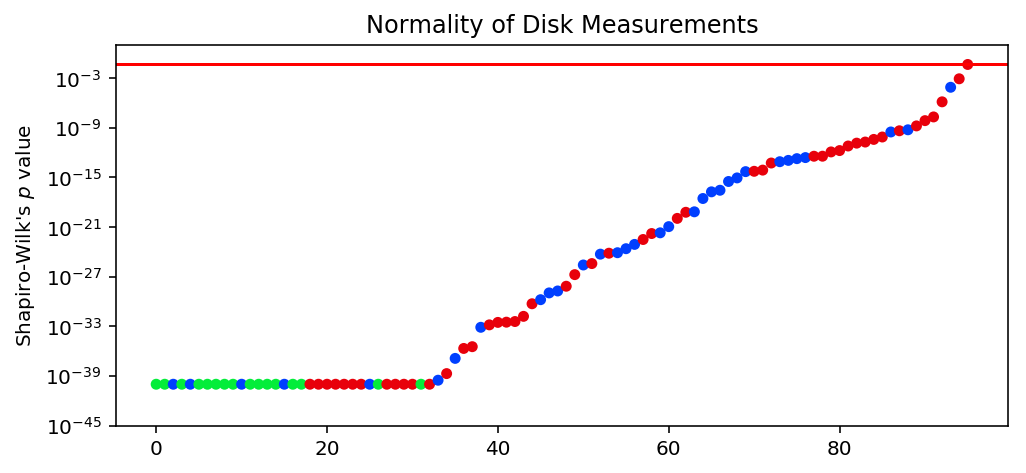

In [37]:
def s_w_plot(df, title="Normality of Measurements", text_zero_tresh=1e-40, ylim=[1.0e-45, 1e1], alpha=0.05 ):

    if text_zero_tresh:
        df.loc[df["S-W Test"] < text_zero_tresh, "S-W Test"] = text_zero_tresh  
    
    # Points above the line show configurations for which we cannot reject the null hypothesis suggesting 
    # that the data is a sample from a normal distribution. For points below the line,
    # we can reject this hypothesis 

    color_map = get_cmap(df, "site")

    print "Total number of studied configurations (points on the following plots): ", len(df)

    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,3.5))

    ax.set_ylabel("Shapiro-Wilk's $p$ value")

    df_sorted = df.sort_values(by=["S-W Test"])
    #display(df_sorted)

    # Assign different colors to points above and below thresh
    #point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")

    point_color = df_sorted["site"].map(color_map)

    ax.scatter(range(len(df_sorted)), df_sorted["S-W Test"], s = 20, marker="o", c=point_color)
    ax.set_yscale('log')
    ax.set_title(title)
    ax.axhline(y=alpha, c = "red")

    if ylim:
        ax.set_ylim(ylim)

    plot_show_and_save(fig, show_only=True)
    
s_w_plot(disk_shapiro_wilk, title="Normality of Disk Measurements")

In [38]:
# Memory Analysis

columns = ["site", "hw_type", "testname", "dvfs", "socket_num"]

df_cols = ['S-W Test', 'length'] + columns 
mem_shapiro_wilk = pd.DataFrame(columns=df_cols)

for key, grp in mem_all.groupby(columns):

    (site, hw_type, testname, dvfs, socket_num) = key

    #z = (subsubgrp["mean"]-subsubgrp["mean"].mean())/subsubgrp["mean"].std()

    mem_shapiro_wilk.loc[len(mem_shapiro_wilk)] = [stats.shapiro(grp["mean"])[1], len(grp), site, hw_type, testname, dvfs, socket_num]
    
print "Total rows: ", len(mem_shapiro_wilk)
mem_shapiro_wilk.sample(20).T

Total rows:  590


,359,21,478,291,556,363,439,212,154,117,474,471,19,158,153,111,579,344,233,28
S-W Test,2.52234e-44,1.26002e-39,0,0,0,7.28381e-36,0,0,0,5.78613e-40,0,0,4.39911e-30,0,3.29861e-33,2.46629e-43,0,0,0,1.52406e-39
length,653,623,1297,2007,1483,653,653,1576,1742,623,1297,1297,741,1742,1576,741,1297,768,1576,623
site,wisc,clemson,wisc,utah,wisc,wisc,wisc,clemson,clemson,clemson,wisc,wisc,clemson,clemson,clemson,clemson,wisc,wisc,clemson,clemson
hw_type,c220g1,c6320,c220g2,m510,c220g2,c220g1,c220g1,c8220,c8220,c6320,c220g2,c220g2,c6320,c8220,c8220,c6320,c220g2,c220g1,c8220,c6320
testname,read_memory_loop,read_memory_avx_omp,read_memory_avx,read_memory_rep_lodsq,write_memory_memset_omp,read_memory_loop_omp,write_memory_nontemporal_sse,write_memory_loop_omp,read_memory_loop,write_memory_rep_stosq_omp,copy_omp,copy,read_memory_avx,read_memory_loop_omp,read_memory_loop,write_memory_nontemporal_sse_omp,write_memory_rep_stosq_omp,copy,write_memory_nontemporal_sse,read_memory_loop_omp
dvfs,no,no,no,yes,yes,no,no,no,yes,no,no,no,yes,yes,no,yes,no,yes,no,no
socket_num,1,1,0,0,0,1,1,0,0,1,0,1,1,0,1,1,1,0,1,0


Total number of studied configurations (points on the following plots):  590


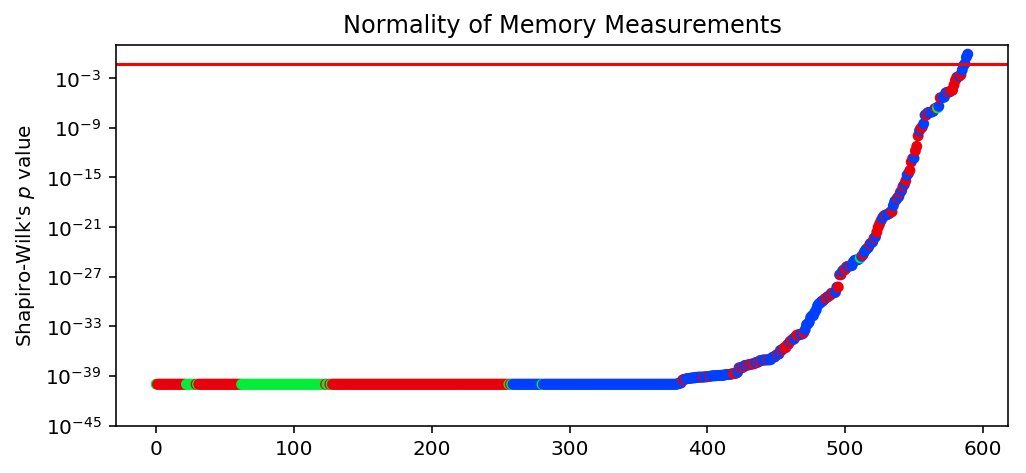

In [39]:
s_w_plot(mem_shapiro_wilk, title="Normality of Memory Measurements")

In [40]:
# Network Analysis

columns = ["site", "hw_type", "rack_local", "test", "directionality"]

df_cols = ['S-W Test', 'length'] + columns 
net_shapiro_wilk = pd.DataFrame(columns=df_cols)

for key, grp in net_all.groupby(columns):

    (site, hw_type, rack_local, test, directionality) = key

    #z = (subsubgrp["mean"]-subsubgrp["mean"].mean())/subsubgrp["mean"].std()

    net_shapiro_wilk.loc[len(net_shapiro_wilk)] = [stats.shapiro(grp["mean"])[1], len(grp), site, hw_type, rack_local, test, directionality]
    
print "Total rows: ", len(net_shapiro_wilk)
net_shapiro_wilk.sample(20).T

Total rows:  27


,24,13,9,11,2,6,19,23,1,10,14,3,5,25,7,12,8,26,21,18
S-W Test,7.03825e-31,0,0,0,2.30103e-31,2.98013e-11,7.72461e-35,9.11162e-15,3.10547e-32,0,9.02804e-21,2.61382e-14,1.56516e-28,3.213e-31,6.31292e-36,1.09924e-25,1.66531e-32,3.05005e-32,2.7196e-11,2.27084e-27
length,415,802,1193,1193,371,404,294,70,371,1193,802,284,284,415,404,802,404,415,70,294
site,wisc,utah,utah,utah,clemson,clemson,wisc,wisc,clemson,utah,utah,clemson,clemson,wisc,clemson,utah,clemson,wisc,wisc,wisc
hw_type,c220g2,m510,m400,m400,c6320,c8220,c220g1,c220g1,c6320,m400,m510,c8220,c8220,c220g2,c8220,m510,c8220,c220g2,c220g1,c220g1
rack_local,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True,False
test,bandwidth,bandwidth,bandwidth,latency,latency,bandwidth,bandwidth,latency,bandwidth,bandwidth,latency,bandwidth,latency,bandwidth,bandwidth,bandwidth,latency,latency,bandwidth,bandwidth
directionality,forward,reverse,forward,forward,forward,forward,reverse,forward,reverse,reverse,forward,forward,forward,reverse,reverse,forward,forward,forward,forward,forward


Total number of studied configurations (points on the following plots):  27


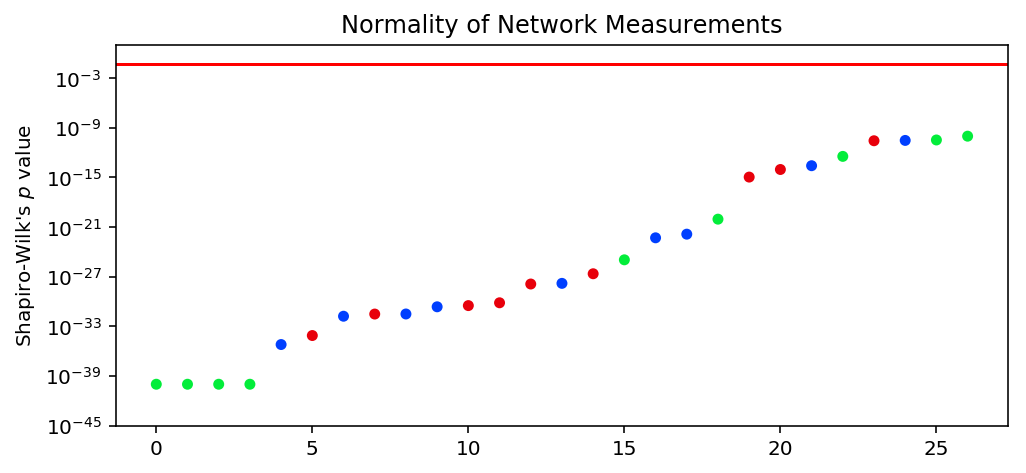

In [41]:
s_w_plot(net_shapiro_wilk, title="Normality of Network Measurements")

Breakdown of disk configs:
	{'wisc': 48, 'utah': 16, 'clemson': 32}
	Number of configs above thresh:  0
	Breakdown for such configs:  {}
	Number of samples for such configs: {'count': 0.0, 'std': nan, 'min': nan, 'max': nan, '50%': nan, '25%': nan, '75%': nan, 'mean': nan}

----------

Breakdown of memory configs:
	{'clemson': 256, 'utah': 78, 'wisc': 256}
	Number of configs above thresh:  3
	Breakdown for such configs:  {'clemson': 3}
	Number of samples for such configs: {'count': 3.0, 'std': 0.0, 'min': 1576.0, 'max': 1576.0, '50%': 1576.0, '25%': 1576.0, '75%': 1576.0, 'mean': 1576.0}


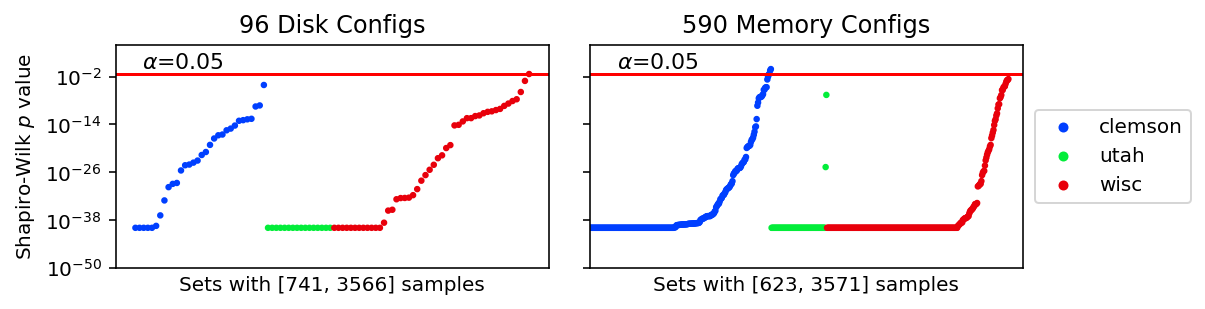

/notebooks/output/paper/normality.pdf

In [42]:
# Produce plots for the paper

# Specified significance level will be shown as a red line; points above will be shown in red, otherwise - blue  
thresh = 0.05

# Points above the line show configurations for which we cannot reject the null hypothesis suggesting 
# that the data is a sample from a normal distribution. For points below the line,
# we can reject this hypothesis 

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,2.5))
ax1.set_ylabel("Shapiro-Wilk $p$ value")

# ---------
# Plot and print disk data
# ---------

#df_sorted = disk_shapiro_wilk.sort_values(by=['all'])
#df_sorted = disk_shapiro_wilk
df_sorted = disk_shapiro_wilk.sort_values(by=['site', 'S-W Test'])

print "Breakdown of disk configs:"
print "\t", dict(df_sorted["site"].value_counts())
print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted['S-W Test'] > thresh])
print "\t", "Breakdown for such configs: ", dict(df_sorted[df_sorted['S-W Test'] > thresh]["site"].value_counts())
print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted['S-W Test'] > thresh]["length"]).describe())

# Assign different colors to points above and below thresh
#point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")
color_map = get_cmap(disk_shapiro_wilk, "site") 
point_color = df_sorted["site"].map(color_map) 

ax1.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted['S-W Test'], label='_nolegend_', s = 5, marker="o", c=point_color)
ax1.set_yscale('log')
ax1.set_title("%d Disk Configs" % (len(df_sorted)))
ax1.axhline(y=thresh, c = "red")
ax1.annotate(r'$\alpha$=%.2f' % thresh, 
             xy=(1, thresh*1.0e1),  
             xycoords='data', fontsize = 11,
             textcoords='offset points')

ax1.set_xlabel("Sets with [%d, %d] samples" % (disk_shapiro_wilk["length"].min(),disk_shapiro_wilk["length"].max()))

# ---------
# Plot and print memory data
# ---------

#df_sorted = mem_shapiro_wilk.sort_values(by=['all'])
#df_sorted = mem_shapiro_wilk
df_sorted = mem_shapiro_wilk.sort_values(by=['site', 'S-W Test'])

print "\n----------\n"
print "Breakdown of memory configs:"
print "\t", dict(mem_shapiro_wilk["site"].value_counts()) 
print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted['S-W Test'] > thresh])
print "\t", "Breakdown for such configs: ", dict(df_sorted[df_sorted['S-W Test'] > thresh]["site"].value_counts())
print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted['S-W Test'] > thresh]["length"]).describe())

# Assign different colors to points above and below thresh
#point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")

color_map = get_cmap(mem_shapiro_wilk, "site") 
point_color = df_sorted["site"].map(color_map) 

#print point_color.value_counts()

ax2.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted['S-W Test'], label='_nolegend_', s = 5, marker="o", c=point_color)
ax2.set_title("%d Memory Configs" % (len(mem_shapiro_wilk)))
ax2.axhline(y=thresh, c = "red")
ax2.annotate(r'$\alpha$=%.2f' % thresh, 
             xy=(10, thresh*1.0e1),  
             xycoords='data', fontsize = 11,
             textcoords='offset points')
ax2.set_xlabel("Sets with [%d, %d] samples" % (mem_shapiro_wilk["length"].min(),mem_shapiro_wilk["length"].max()))
ax2.set_xlim([0, len(df_sorted) + 20])

ax1.set_ylim([1.0e-50, 1000000])

fig.tight_layout()
plt.subplots_adjust(right=0.9);

for k in sorted(color_map.keys()):
    ax1.scatter([], [], s=100, marker=".", c = color_map[k], lw=0.0, label=k);

ax1.legend(loc='center left', bbox_to_anchor=(2.1, 0.5),
           fancybox=True, shadow=False, ncol=1, fontsize = 10) 

ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])

plot_show_and_save(fig, "normality.pdf", dest_dir)

Breakdown of disk configs:
	{'wisc': 48, 'utah': 16, 'clemson': 32}
	Number of configs above thresh:  0
	Sites in such configs:  {}
	Number of samples for such configs: {'count': 0.0, 'std': nan, 'min': nan, 'max': nan, '50%': nan, '25%': nan, '75%': nan, 'mean': nan}

Breakdown of memory configs:
	{'clemson': 256, 'utah': 78, 'wisc': 256}
	Number of configs above thresh:  3
	Sites in such configs:  {'clemson': 3}
	Number of samples for such configs: {'count': 3.0, 'std': 0.0, 'min': 1576.0, 'max': 1576.0, '50%': 1576.0, '25%': 1576.0, '75%': 1576.0, 'mean': 1576.0}

Breakdown of network configs:
	{'wisc': 9, 'utah': 9, 'clemson': 9}
	Number of configs above thresh:  0
	Sites in such configs:  {}
	Number of samples for such configs: {'count': 0.0, 'std': nan, 'min': nan, 'max': nan, '50%': nan, '25%': nan, '75%': nan, 'mean': nan}


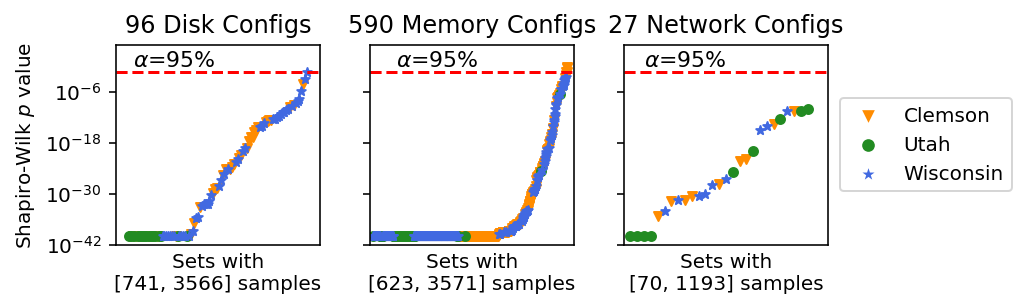

/notebooks/output/paper/normality.pdf

In [70]:
# Produce plots for the paper

marker_map = {"clemson": "v", "utah": "o", "wisc": "*"}
#color_map = get_cmap(disk_shapiro_wilk, "site") 
color_map = {"clemson": "darkorange", "utah": "forestgreen", "wisc": "royalblue"}
marker_size = 20

# Specified significance level will be shown as a red line; points above will be shown in red, otherwise - blue  
thresh = 0.05

# Points above the line show configurations for which we cannot reject the null hypothesis suggesting 
# that the data is a sample from a normal distribution. For points below the line,
# we can reject this hypothesis 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(6.5,2.5))
ax1.set_ylabel("Shapiro-Wilk $p$ value")

# ---------
# Plot and print disk data
# ---------

#df_sorted = disk_shapiro_wilk.sort_values(by=['site', 'S-W Test'])
df_sorted = disk_shapiro_wilk.sort_values(by=["S-W Test"])

print "Breakdown of disk configs:"
print "\t", dict(df_sorted["site"].value_counts())
print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted['S-W Test'] > thresh])
print "\t", "Sites in such configs: ", dict(df_sorted[df_sorted['S-W Test'] > thresh]["site"].value_counts())
print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted['S-W Test'] > thresh]["length"]).describe())
df_sorted["idx"] = range(len(df_sorted))

# Assign different colors to points above and below thresh
#point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")

#point_color = df_sorted["site"].map(color_map) 

#ax1.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted['S-W Test'], label='_nolegend_', s = 5, marker=list(point_marker), c=point_color)
for df_site, grp in df_sorted.groupby("site"): 
    ax1.scatter(grp["idx"], grp['S-W Test'], label='_nolegend_', s = marker_size, marker=marker_map[df_site], c=color_map[df_site])

ax1.set_yscale('log')
ax1.set_title("%d Disk Configs" % (len(df_sorted)))
ax1.axhline(y=thresh, c = "red", linestyle='--')
ax1.annotate(r'$\alpha$=%d%%' % int((1-thresh) * 100), 
             xy=(1, thresh*1.0e1),  
             xycoords='data', fontsize = 11,
             textcoords='offset points')

ax1.set_xlabel("Sets with\n[%d, %d] samples" % (disk_shapiro_wilk["length"].min(),disk_shapiro_wilk["length"].max()))

# ---------
# Plot and print memory data
# ---------

#df_sorted = mem_shapiro_wilk.sort_values(by=['site', 'S-W Test'])
df_sorted = mem_shapiro_wilk.sort_values(by=["S-W Test"])

print "\nBreakdown of memory configs:"
print "\t", dict(mem_shapiro_wilk["site"].value_counts()) 
print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted['S-W Test'] > thresh])
print "\t", "Sites in such configs: ", dict(df_sorted[df_sorted['S-W Test'] > thresh]["site"].value_counts())
print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted['S-W Test'] > thresh]["length"]).describe())
df_sorted["idx"] = range(len(df_sorted))

# Assign different colors to points above and below thresh
#point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")

#color_map = get_cmap(mem_shapiro_wilk, "site") 
point_color = df_sorted["site"].map(color_map) 

#print point_color.value_counts()

#ax2.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted['S-W Test'], label='_nolegend_', s = 5, marker="o", c=point_color)
for df_site, grp in df_sorted.groupby("site"): 
    ax2.scatter(grp["idx"], grp['S-W Test'], label='_nolegend_', s = marker_size, marker=marker_map[df_site], c=color_map[df_site])

ax2.set_title("%d Memory Configs" % (len(mem_shapiro_wilk)))
ax2.axhline(y=thresh, c = "red", linestyle='--')
ax2.annotate(r'$\alpha$=%d%%' % int((1-thresh) * 100), 
             xy=(10, thresh*1.0e1),  
             xycoords='data', fontsize = 11,
             textcoords='offset points')
ax2.set_xlabel("Sets with\n[%d, %d] samples" % (mem_shapiro_wilk["length"].min(),mem_shapiro_wilk["length"].max()))
ax2.set_xlim([-10, len(df_sorted) + 20])

# ---------
# Plot and print network data
# ---------

#df_sorted = mem_shapiro_wilk.sort_values(by=['site', 'S-W Test'])
df_sorted = net_shapiro_wilk.sort_values(by=["S-W Test"])

print "\nBreakdown of network configs:"
print "\t", dict(net_shapiro_wilk["site"].value_counts()) 
print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted['S-W Test'] > thresh])
print "\t", "Sites in such configs: ", dict(df_sorted[df_sorted['S-W Test'] > thresh]["site"].value_counts())
print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted['S-W Test'] > thresh]["length"]).describe())
df_sorted["idx"] = range(len(df_sorted))

# Assign different colors to points above and below thresh
#point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")

#color_map = get_cmap(net_shapiro_wilk, "site") 
#point_color = df_sorted["site"].map(color_map) 

#print point_color.value_counts()

#ax3.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted['S-W Test'], label='_nolegend_', s = 5, marker="o", c=point_color)
for df_site, grp in df_sorted.groupby("site"): 
    ax3.scatter(grp["idx"], grp['S-W Test'], label='_nolegend_', s = marker_size, marker=marker_map[df_site], c=color_map[df_site])

ax3.set_title("%d Network Configs" % (len(net_shapiro_wilk)))
ax3.axhline(y=thresh, c = "red", linestyle='--')
ax3.annotate(r'$\alpha$=%d%%' % int((1-thresh) * 100), 
             xy=(1.5, thresh*1.0e1),  
             xycoords='data', fontsize = 11,
             textcoords='offset points')
ax3.set_xlabel("Sets with\n[%d, %d] samples" % (net_shapiro_wilk["length"].min(),net_shapiro_wilk["length"].max()))
ax3.set_xlim([-1, len(df_sorted) + 2])

# Additional styling
ax1.set_ylim([1.0e-42, 1e5])

fig.tight_layout()
plt.subplots_adjust(right=0.9);

for k in sorted(color_map.keys()):
    ax2.scatter([], [], s=40, marker=marker_map[k], c = color_map[k], lw=0.0, label=k.title().replace("Wisc", "Wisconsin"));
ax2.legend(loc='center left', bbox_to_anchor=(2.25, 0.5),
           fancybox=True, shadow=False, ncol=1, fontsize = 10) 

ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])

#yticks = ax1.get_yticks().tolist() # get list of ticks
#yticklabs = list(ax1.get_yticklabels()) # get list of ticks
#print yticks, yticklabs
# 
# ax1.set_yticklabels(yticklabs[:-3])  
# ax1.set_yticks(yticks[:-3])

# ax2.set_yticklabels(yticklabs[:-3])  
# ax2.set_yticks(yticks[:-3])

# ax3.set_yticklabels(yticklabs[:-3])  
# ax3.set_yticks(yticks[:-3])
# set the labels

plot_show_and_save(fig, "normality.pdf", dest_dir)

In [13]:
# # Produce plots for the paper

# # Specified significance level will be shown as a red line; points above will be shown in red, otherwise - blue  
# thresh = 0.05

# # Points above the line show configurations for which we cannot reject the null hypothesis suggesting 
# # that the data is a sample from a normal distribution. For points below the line,
# # we can reject this hypothesis 

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True, figsize=(8,8))

# def plot_disk_and_mem(field, ax1, ax2, print_info=False, show_legend=False, shared_x_label=""):
#     ax1.set_ylabel("Shapiro-Wilk $p$ value")
    
#     # ---------
#     # Plot and print disk data
#     # ---------

#     #df_sorted = disk_shapiro_wilk.sort_values(by=['all'])
#     #df_sorted = disk_shapiro_wilk
#     df_sorted = disk_shapiro_wilk.sort_values(by=['site', field])

#     if print_info:
#         print "Breakdown of disk configs:"
#         print "\t", dict(df_sorted["site"].value_counts())
#         print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted[field] > thresh])
#         print "\t", "Breakdown for such configs: ", dict(df_sorted[df_sorted[field] > thresh]["site"].value_counts())
#         print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted[field] > thresh]["length"]).describe())

#     # Assign different colors to points above and below thresh
#     #point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")
#     color_map = get_cmap(disk_shapiro_wilk, "site") 
#     point_color = df_sorted["site"].map(color_map) 

#     ax1.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted[field], label='_nolegend_', s = 5, marker="o", c=point_color)
#     ax1.set_yscale('log')
#     ax1.set_title("%d Disk Configs" % (len(df_sorted)))
#     ax1.axhline(y=thresh, c = "red")
#     ax1.annotate(r'$\alpha$=%.2f' % thresh, 
#                  xy=(1, thresh*1.0e1),  
#                  xycoords='data', fontsize = 11,
#                  textcoords='offset points')

#     if not shared_x_label:
#         ax1.set_xlabel("Sets with [%d, %d] samples" % (disk_shapiro_wilk["length"].min(),disk_shapiro_wilk["length"].max()))
#     else:
#         ax1.set_xlabel(shared_x_label)
        
#     # ---------
#     # Plot and print memory data
#     # ---------

#     #df_sorted = mem_shapiro_wilk.sort_values(by=['all'])
#     #df_sorted = mem_shapiro_wilk
#     df_sorted = mem_shapiro_wilk.sort_values(by=['site', field])

#     if print_info:
#         print "\n----------\n"
#         print "Breakdown of memory configs:"
#         print "\t", dict(mem_shapiro_wilk["site"].value_counts()) 
#         print "\t", "Number of configs above thresh: ", len(df_sorted[df_sorted[field] > thresh])
#         print "\t", "Breakdown for such configs: ", dict(df_sorted[df_sorted[field] > thresh]["site"].value_counts())
#         print "\t", "Number of samples for such configs:", dict(pd.to_numeric(df_sorted[df_sorted[field] > thresh]["length"]).describe())

#     # Assign different colors to points above and below thresh
#     #point_color = vals.apply(lambda x: "blue" if x <= thresh else "red")

#     color_map = get_cmap(mem_shapiro_wilk, "site") 
#     point_color = df_sorted["site"].map(color_map) 

#     #print point_color.value_counts()

#     ax2.scatter(np.linspace(0, len(df_sorted), len(df_sorted)), df_sorted[field], label='_nolegend_', s = 5, marker="o", c=point_color)
#     ax2.set_title("%d Memory Configs" % (len(vals)))
#     ax2.axhline(y=thresh, c = "red")
#     ax2.annotate(r'$\alpha$=%.2f' % thresh, 
#                  xy=(10, thresh*1.0e1),  
#                  xycoords='data', fontsize = 11,
#                  textcoords='offset points')
    
#     fig.tight_layout()
    
#     if not shared_x_label:
#         ax2.set_xlabel("Sets with [%d, %d] samples" % (mem_shapiro_wilk["length"].min(),mem_shapiro_wilk["length"].max()))
#     else:
#         #lc = ax2.xaxis.get_label_coords()
#         #ax2.xaxis.set_label_coords(0.1, -0.025)
#         ax2.set_xlabel(shared_x_label)
    
#     ax2.set_xlim([0, len(df_sorted) + 20])
    
#     ax1.set_ylim([1.0e-50, 1000000])
    
#     plt.subplots_adjust(right=0.9);

#     if show_legend:
#         for k in sorted(color_map.keys()):
#             ax1.scatter([], [], s=100, marker=".", c = color_map[k], lw=0.0, label=k);

#         ax1.legend(loc='center left', bbox_to_anchor=(2.1, 0.5),
#                    fancybox=True, shadow=False, ncol=1, fontsize = 10) 

#     ax1.get_xaxis().set_ticks([])
#     ax2.get_xaxis().set_ticks([])
    
# plot_disk_and_mem("all", ax1, ax2)
# plot_disk_and_mem(100, ax3, ax4, show_legend=True, shared_x_label='Subsets with 100 samples\n(randomly selected)')
# plot_disk_and_mem(20, ax5, ax6, shared_x_label='Subsets with 20 samples\n(randomly selected)')

# plot_show_and_save(fig, "normality-detailed.pdf", dest_dir)

In [14]:
def nodes_with_num_observations_greater_than(data, cnt):
    output = pd.DataFrame()
    for t in data['testname'].unique():
        subdf = data.query('testname == @t')
        output = output.append(subdf[subdf['nodeuuid'].isin(subdf['nodeuuid'].value_counts()[subdf.groupby('nodeuuid')['nodeuuid'].count() > cnt].index)])
        
    return output

In [19]:
raw_mem_all, mem_all = process_memory(db)
mem_all_filtered = nodes_with_num_observations_greater_than(mem_all, 50)

columns = ["site", "hw_type", "nodeuuid", "testname", "dvfs", "socket_num"]
df_cols = ['S-W Test', 'length'] + columns

mem_shapiro_wilk = pd.DataFrame(columns=df_cols)

for key, grp in mem_all_filtered.groupby(columns):
    (site, hw_type, nodeuuid, testname, dvfs, socket_num) = key
    mem_shapiro_wilk.loc[len(mem_shapiro_wilk)] = [stats.shapiro(grp["mean"])[1], len(grp), site, hw_type, nodeuuid, testname, dvfs, socket_num]
    
print "Total rows: ", len(mem_shapiro_wilk)
mem_shapiro_wilk.sample(20).T

Total rows:  11530


,6416,6488,606,3233,338,6434,5908,7421,913,6061,5854,7787,10902,7024,9894,7912,3886,6392,8810,786
S-W Test,0.270321,0.220721,4.64063e-08,0.000953356,2.61635e-07,0.239461,0.0289492,0.879143,0.00592533,0.242541,0.973311,0.0296777,0.974484,0.0843119,0.000438145,0.0188214,0.359943,0.0817978,1.72868e-13,0.0435009
length,26,41,21,14,30,26,77,15,13,56,18,15,29,23,18,14,17,26,74,15
site,utah,utah,clemson,clemson,clemson,utah,utah,wisc,clemson,utah,clemson,wisc,wisc,wisc,wisc,wisc,clemson,utah,wisc,clemson
hw_type,m510,m510,c6320,c8220,c6320,m510,m400,c220g1,c6320,m400,c8220,c220g1,c220g2,c220g1,c220g2,c220g1,c8220,m510,c220g2,c6320
nodeuuid,c2af7bcb-8fea-11e6-8c08-a53a3a50acf8,c576c0a9-8fea-11e6-8c08-a53a3a50acf8,63911c04-fee2-11e5-ba07-000099989701,cf9494ea-d7f1-11e4-b34b-000099989701,37352ae4-fee3-11e5-ba07-000099989701,c2af7bcb-8fea-11e6-8c08-a53a3a50acf8,2f9f2f0f-72db-11e4-85c8-179a28bd1b8c,ae1caad6-0341-11e6-a488-a3bb994732a6,d3b5fcae-fee3-11e5-ba07-000099989701,697d6502-72da-11e4-85c8-179a28bd1b8c,d5e8a1d8-d7f1-11e4-b34b-000099989701,af77ad04-0341-11e6-a488-a3bb994732a6,50c8501e-e8d4-11e5-a488-a3bb994732a6,7e360fbe-22b1-11e6-8934-779211246dcb,1a9ff8c2-e8ec-11e5-a488-a3bb994732a6,b873d61c-0336-11e6-a488-a3bb994732a6,d055b59c-d7f1-11e4-b34b-000099989701,b0f2445d-8fdf-11e6-8c08-a53a3a50acf8,18fc3782-e8ec-11e5-a488-a3bb994732a6,ce874ed0-fee2-11e5-ba07-000099989701
testname,copy_omp,read_memory_loop_omp,write_memory_memset_omp,read_memory_prefetch_avx,write_memory_loop,read_memory_sse,scale,write_memory_rep_stosq,read_memory_avx,read_memory_loop_omp,write_memory_memset_omp,write_memory_nontemporal_avx,copy_omp,write_memory_nontemporal_avx_omp,read_memory_loop_omp,write_memory_memset_omp,read_memory_rep_lodsq_omp,write_memory_memset_omp,write_memory_nontemporal_avx,read_memory_avx
dvfs,no,no,yes,no,yes,no,yes,yes,no,yes,yes,no,no,yes,no,yes,yes,no,no,yes
socket_num,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0


Total number of studied configurations (points on the following plots):  11530


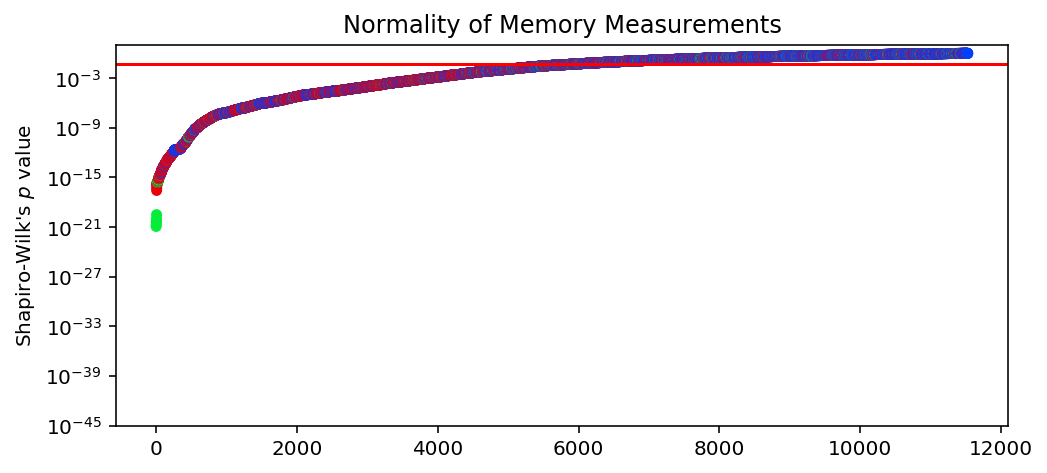

In [20]:
s_w_plot(mem_shapiro_wilk, title="Normality of Memory Measurements")

In [21]:
print "Total:", len(mem_shapiro_wilk)
print "Can be considered normal:", len(mem_shapiro_wilk[mem_shapiro_wilk["S-W Test"] >= 0.05])

Total: 11530
Can be considered normal: 5597


In [17]:
plot_show_and_save(fig, "single-node-normality.pdf", dest_dir)

NameError: name 'fig' is not defined